In [30]:
from sage.all import *
import numpy as np
from PIL import Image
import wave
import struct


# 1. Стеганография синдромным вложением на основе кодов Хэмминга

In [37]:

# здесь смешиваются незнание структуры Sage и 
class HammingSteganography:
    def __init__(self, m=3):
        """
        Инициализация с параметром m (для кода Хэмминга (n=2^m-1, k=n-m) fun fact)
        """
        self.m = m
        self.n = 2**m - 1  # длина кодового слова
        
        # Генерация проверочной матрицы Хэмминга
        # self.H = codes.HammingCode(GF(2), self.m).parity_check_matrix() # тут матрица нетрадиционная. Наверное её генерируют через преобразование Фурри.
        # print(self.H)
    
    def fast_hamming_parity_check(self, message):
        enc = 0
        for i in range(1, self.n + 1):
            # check ^^ or ^ 
            enc = (int(message[i - 1]) * i) ^^ enc
            # print(f'fhpc{i}',enc, message[i - 1], i, message[i - 1] * i)
        # enc += 1
        # print('fhe', message, enc)
        
        # lost generation of coders
        syndrome = zero_vector(GF(2), self.m)
        ind = self.m - 1
        while enc > 0:
            syndrome[ind] = enc % 2
            ind -= 1
            enc //= 2
        
        return syndrome

    def message_normalize(self, message):
        if isinstance(message, list):
            return message
        
        raise "Literally 1984"
                
    
    def inject(self, container, message):
        """
        Встраивание сообщения message в контейнер container.
        Зависит от ошибки fabric. Учитывает синдром details.
        
        Args:
            container: исходный контейнер (вектор длины n)
            message: скрытое сообщение (вектор длины m)
        
        Returns:
            sus_container: измененный контейнер
        """
        # Преобразуем входные данные в векторы над GF(2)
        cont_vec = container
        message_vec = message
    
        # Вычисляем текущий синдром
        current_syndrome =  self.fast_hamming_parity_check(cont_vec)
        # Вычисляем целевой синдром
        target_syndrome = message_vec
        # Вычисляем разность синдромов
        # print(target_syndrome, current_syndrome)
        syndrome_diff = list(vector(GF(2), target_syndrome) + vector(GF(2),current_syndrome))
        # print(current_syndrome, target_syndrome, syndrome_diff)
        
        # Ищем вектор ошибки веса ≤ 1
        error = self._find_error_vector(syndrome_diff)
        # Вычисляем измененный контейнер
        container_sus = vector(GF(2), cont_vec) + error
        # print('sus', container_sus)
        
        return list(container_sus), list(error)
    
    def _find_error_vector(self, target):
        """
        Находит вектор ошибки e веса ≤ 1 такой, что его Н*е^Т = target (Такой есть)
        """
        # print('needed diff', target)
        e = zero_vector(GF(2), self.n)
        
        # assembler like
        ind = 0
        bp = 1
        for i in range(len(target) - 1, -1, -1):
            ind += int(target[i]) * bp
            bp *= 2

        # print('error coord', ind)
        if ind != 0:
            e[ind - 1] = 1
        
        return e
    
    def extract(self, poisoned_container):
        """
        Извлечение скрытого сообщения из контейнера
        
        Args:
            poisoned_container: стеганоконтейнер (вектор длины n)
        
        Returns:
            message: извлеченное сообщение (вектор длины m)
        """
        # x_vec = vector(GF(2), poisoned_container)
        # message = self.H * x_vec
        # return list(message)
        message = self.fast_hamming_parity_check(poisoned_container)
        return message

In [38]:
cont = [1,0,1,1,1,0,1]
m = [0, 0, 0]
stg = HammingSteganography(m=len(m))
print('initial',cont, m)

cunt, err = stg.inject(cont, m)
print('steganosaurus',cunt)

received_m = stg.extract(cunt)

print('decoded message', received_m)

initial [1, 0, 1, 1, 1, 0, 1] [0, 0, 0]
steganosaurus [1, 0, 1, 0, 1, 0, 1]
decoded message (0, 0, 0)


# 2. Интеграция с медиа-контейнером с lsb

In [39]:
class ImageSteganography:
    def __init__(self, m=3, max_message_length = int(2 ** 32) - 1):
        self.hamming = HammingSteganography(m)
        self.n = self.hamming.n
        self.m = self.hamming.m
        self.max_message_length = max_message_length + 1
        self.max_embeded_size_bits = math.ceil(math.ceil(math.log(self.max_message_length, 2)) / self.m) * self.m
        # print('max bits', self.max_embeded_size_bits, math.floor(math.log(self.max_message_length, 2)) + 1)
    
    def extract_lsb_sequence(self, image_path):
        """
        Извлекает последовательность LSB из изображения
        """
        img = Image.open(image_path)
        img_array = np.array(img)
        
        # Преобразуем в одномерный массив и извлекаем LSB
        flat_array = img_array.flatten()
        lsb_sequence = [pixel & 1 for pixel in flat_array]
        
        return lsb_sequence, img_array.shape
    
    @staticmethod
    def process_message(message):
        if isinstance(message, str):
            return ImageSteganography._string_to_bitarray(message)
        if isinstance(message, list):
            if all(isinstance(x, Integer) for x in message):
                return ImageSteganography._integer_to_bitarray(message)
        raise "Incorrect message type [0,1]-list or string required"

    def add_length_data(self, message_bits):
        if len(message_bits) > self.max_message_length:
            raise "Too long message, increase max_message_length"

        size = ImageSteganography._integer_to_bitarray(len(message_bits), self.max_embeded_size_bits)
        new_bits = size + message_bits

        # print(size)
        # print()
        # print(message_bits)
        # print()
        # print(new_bits)

        return new_bits
    
    def embed_message(self, image_path, message, output_path=None):
        """
        Встраивает сообщение в изображение
        """
        
        message_bits = ImageSteganography.process_message(message)
        lengthened_message_bits = self.add_length_data(message_bits)

        if output_path is None:
            output_path = ImageSteganography._create_stego_name(image_path)
        
        # Извлекаем LSB последовательность
        lsb_sequence, original_shape = self.extract_lsb_sequence(image_path)

        # print('lengthened message len', len(lengthened_message_bits), self.m, len(message_bits))
        
        # Разбиваем сообщение на блоки длины m
        message_blocks = [lengthened_message_bits[i:i+self.m] for i in range(0, len(lengthened_message_bits), self.m)]
        # print('blocks', message_blocks)
        
        # Дополняем последний блок нулями если необходимо
        if len(message_blocks[-1]) < self.m:
            message_blocks[-1] = message_blocks[-1] + [0] * (self.m - len(message_blocks[-1]))
        
        # Разбиваем LSB на блоки длины n
        lsb_blocks = [lsb_sequence[i:i+self.n] for i in range(0, len(lsb_sequence), self.n)]
        
        # Проверяем, что хватит места для сообщения
        if len(message_blocks) > len(lsb_blocks):
            raise ValueError("Сообщение слишком длинное для данного контейнера")
        
        # Встраиваем сообщение
        modified_lsb = []
        changes_count = 0
        
        for i in range(len(message_blocks)):
            if i < len(lsb_blocks):
                block = lsb_blocks[i]
                if len(block) < self.n:
                    # Дополняем последний блок нулями
                    block = block + [0] * (self.n - len(block))
                
                # Встраиваем сообщение
                modified_block, error_vector = self.hamming.inject(block, message_blocks[i])
                modified_lsb.extend(modified_block)
                changes_count += sum(error_vector)
            else:
                break
        
        # Добавляем оставшиеся блоки без изменений
        for i in range(len(message_blocks), len(lsb_blocks)):
            block = lsb_blocks[i]
            if len(block) < self.n:
                block = block + [0] * (self.n - len(block))
            modified_lsb.extend(block)
        # print('modded lsbs', modified_lsb[:50])
        
        # Создаем модифицированное изображение
        self._create_stego_image(image_path, modified_lsb, original_shape, output_path)
        
        return output_path, changes_count, len(lengthened_message_bits)
    
    def extract_message(self, stego_image_path):
        """
        Извлекает сообщение из стегоизавра
        """
        
        lsb_sequence, _ = self.extract_lsb_sequence(stego_image_path)
        
        # Разбиваем на блоки
        lsb_blocks = [lsb_sequence[i:i+self.n] for i in range(0, len(lsb_sequence), self.n)]
        # print('len blocks', len(lsb_blocks))
        # print('blocks', lsb_blocks[:6])

        length_blocks_num = (self.max_embeded_size_bits + self.m - 1) // self.m

        length_bits = []
        
        for i in range(length_blocks_num):
            # print(i)
            if i < len(lsb_blocks):
                block = lsb_blocks[i]
                if len(block) < self.n:
                    block = block + [0] * (self.n - len(block))
                
                message_bits = self.hamming.extract(block)
                length_bits.extend(message_bits)
                
                # print('block', block)
                
                # print('mess bits', message_bits)
            else:
                break

        message_length_bits = int(ImageSteganography._bitarray_to_integer(list(length_bits)))
        # print('len bits, mes len bit, lbn', length_bits, message_length_bits, length_blocks_num)
        
        # Вычисляем количество блоков для извлечения
        num_blocks = (message_length_bits + self.m - 1) // self.m
        # print('num blocks', num_blocks)
        
        extracted_bits = []
        
        for i in range(length_blocks_num, num_blocks + length_blocks_num):
            # print(i)
            if i < len(lsb_blocks):
                block = lsb_blocks[i]
                if len(block) < self.n:
                    block = block + [0] * (self.n - len(block))
                
                message_bits = self.hamming.extract(block)
                extracted_bits.extend(message_bits)
            else:
                break
        
        # Обрезаем до нужной длины
        return extracted_bits[:message_length_bits]
    
    def _create_stego_image(self, original_path, modified_lsb, original_shape, output_path):
        """
        Создает стегоизображение с модифицированными LSB
        """
        
        img = Image.open(original_path)
        img_array = np.array(img)
        flat_array = img_array.flatten()
        
        # Модифицируем LSB
        for i in range(len(modified_lsb)):
            if i < len(flat_array):
                # Сохраняем старшие биты, меняем только младший
                flat_array[i] = (int(flat_array[i]) & -2) | int(modified_lsb[i]) # -2 == ~1r НО ~1r не работает. И ~1 и не int(~1) или ~Integer(1) тоже
        
        # Восстанавливаем исходную форму
        stego_array = flat_array.reshape(original_shape)
        
        # Сохраняем изображение
        stego_img = Image.fromarray(stego_array)
        stego_img.save(output_path)

    @staticmethod
    def _create_stego_name(original_path):
        import os
        dr = os.path.dirname(original_path)
        fn = os.path.basename(original_path)
        fname = os.path.splitext(fn)[0]
        fext = os.path.splitext(fn)[1]
        
        return os.path.join(dr, fname + '_modiffied' + fext)

    @staticmethod
    def _string_to_bitarray(message, encoding='utf-16'):
        bytes_data = message.encode(encoding)
        bits = []
        for byte in bytes_data:
            bits.extend([(byte >> (7 - i)) & 1 for i in range(8)])
        return bits

    @staticmethod
    def _integer_to_bitarray(num, length=None):
        if length is None:
            length = math.floor(math.log(num, 2) + 1)
        bits = [0] * length
        # print(bits, len(bits), num, (math.log(num, 2)))
        ind = len(bits) - 1
        while num > 0:
            bits[ind] = num % 2
            num //= 2
            ind -= 1
        return bits

    @staticmethod
    def _bitarray_to_integer(bitarray):
        bp = 1
        num = 0
        # print('bitarr length', bitarray, len(bitarray))
        for i in range(len(bitarray) -1, -1, -1):
            num += int(bitarray[i]) * bp
            bp *= 2
            # print(i, num, bp, bitarray[i])
        # print('bitarr to int', num)
        return num

    @staticmethod
    def _bitarray_to_string(bitarray, encoding='utf-16'):
        if len(bitarray) % 8 != 0:
            raise ValueError(f"Длина массива битов ({len(bitarray)}) должна быть кратна 8")
    
        bytes_list = []
        
        # Обрабатываем по 8 бит (1 байт)
        for i in range(0, len(bitarray), 8):
            byte_bits = bitarray[i:i+8]
            
            # Собираем байт из битов
            byte_value = 0
            for j, bit in enumerate(byte_bits):
                byte_value = (byte_value << int(1)) | int(bit)
            
            bytes_list.append(byte_value)
        
        # Преобразуем список байтов в bytes объект
        bytes_data = bytes(bytes_list)
        
        # Декодируем обратно в строку
        try:
            return bytes_data.decode(encoding)
        except UnicodeDecodeError as e:
            raise ValueError(f"Ошибка декодирования: {e}. Проверьте кодировку '{encoding}'")

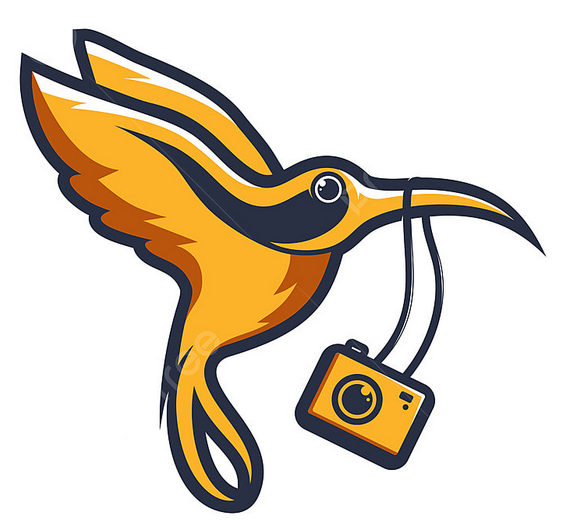

In [40]:
pic_path = '/home/riku/Documents/crypto/Indiv/assets/pov_kanya.png'

Image.open(pic_path)

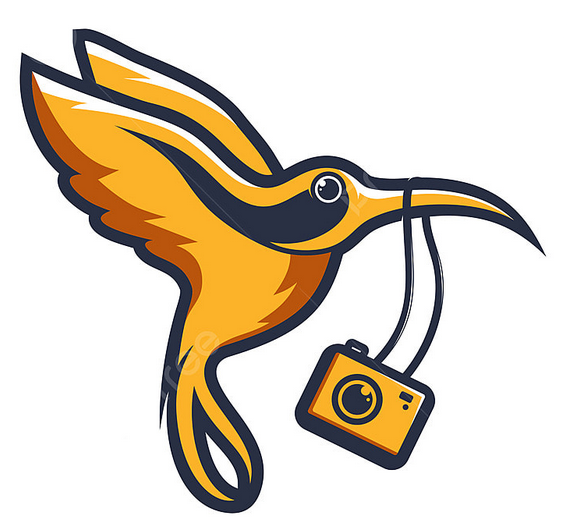

In [45]:
# message = "Скиньте программу коллока🥲"
message = 'hahahahahahahahahahahahahahahahahahhahahahahahahhahahaha🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣 🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣rip'
# message = 'meowа'
message_size = len(ImageSteganography.process_message(message))
message_bitarray = ImageSteganography.process_message(message)

im_stg = ImageSteganography(m=8)

stg_path, a, b = im_stg.embed_message(pic_path, message)

Image.open(stg_path)

In [46]:
# TODO в первые 16/32 бита сообщения пусть кодируют его длину
# res = im_stg.extract_message(stg_path, message_size)
res = im_stg.extract_message(stg_path)

print(f'✨Message extracted correctly!✨' if res == message_bitarray else f'Incorrect extraction 😠')

r = ImageSteganography._bitarray_to_string(res)

print(f'Message: {r}')

✨Message extracted correctly!✨
Message: hahahahahahahahahahahahahahahahahahhahahahahahahhahahaha🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣 🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣rip


# 3. Статистические тесты и анализ

In [8]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import subprocess
import os
import tempfile

# Если установлен sp800_22_tests
try:
    from sp800_22_tests import *
    USE_SP800 = True
except ImportError:
    USE_SP800 = False
    print("sp800_22_tests не установлен, будем использовать локальный assess")

class NISTSteganographyAnalysis:
    def __init__(self, image_stego, nist_path='./NIST-Statistical-Test-Suite-master/sts/assess'):
        self.image_stego = image_stego
        self.nist_path = nist_path
        self.use_assess = os.path.exists(nist_path)
        
        if self.use_assess:
            print(f"✓ Найден NIST assess: {nist_path}")
        else:
            print(f"⚠ NIST assess не найден: {nist_path}")
            print(f"  Будут использованы только базовые тесты")
    
    def extract_lsb_bits(self, image_path):
        """Извлекает последовательность LSB из изображения"""
        img = Image.open(image_path)
        img_array = np.array(img)
        flat_array = img_array.flatten()
        lsb_sequence = [pixel & 1 for pixel in flat_array]
        return lsb_sequence
    
    def run_nist_assess(self, bit_sequence, test_name="Unknown"):
        """
        Запускает оригинальный NIST assess на последовательности битов
        """
        if not self.use_assess:
            print("⚠ assess не найден, используем базовые тесты")
            return self._basic_statistical_tests(bit_sequence)
        
        print(f"\n{'='*60}")
        print(f"NIST Statistical Tests (assess) для: {test_name}")
        print(f"Длина последовательности: {len(bit_sequence)} бит")
        print(f"{'='*60}\n")
        
        # Получаем директорию где лежит assess
        assess_dir = os.path.dirname(os.path.abspath(self.nist_path))
        
        # Создаем файл с битами (относительный путь от assess_dir)
        data_filename = 'test_data_stego.txt'
        data_file = os.path.join(assess_dir, data_filename)
        
        with open(data_file, 'w') as f:
            # assess ожидает биты в текстовом формате ASCII (0 и 1)
            f.write(''.join(map(str, bit_sequence)))
        
        try:
            # Интерактивный диалог с assess:
            # 1. Enter Choice (Generator): 0 - Input File
            # 2. User Prescribed Input File: имя_файла
            # 3. Enter Choice (Apply all tests): 1 - YES
            # 4. Select Test (Parameter Adjustments): 0 - continue
            # 5. How many bitstreams?: 1
            # 6. Select input mode: 0 - ASCII
            
            assess_input = f"""0
{data_filename}
1
0
1
0
"""
            
            print(f"Запуск assess с параметрами:")
            print(f"  Длина: {len(bit_sequence)} бит")
            print(f"  Файл: {data_filename}")
            print(f"  Команда: {self.nist_path} {len(bit_sequence)}")
            print()
            
            result = subprocess.run(
                [self.nist_path, str(len(bit_sequence))],
                input=assess_input,
                text=True,
                capture_output=True,
                cwd=assess_dir,
                timeout=180
            )
            
            print("="*60)
            print("STDOUT от assess:")
            print("="*60)
            print(result.stdout)
            
            if result.stderr:
                print("\n" + "="*60)
                print("STDERR от assess:")
                print("="*60)
                print(result.stderr)
            
            if result.returncode != 0:
                print(f"\n⚠ assess завершился с кодом {result.returncode}")
            
            # Парсим результаты из файлов
            results = self._parse_assess_results(assess_dir)
            
            return results
            
        except subprocess.TimeoutExpired:
            print("⚠ Timeout при выполнении assess (>180 сек)")
            return {}
        except Exception as e:
            print(f"⚠ Ошибка при запуске assess: {e}")
            import traceback
            traceback.print_exc()
            return {}
        finally:
            # Удаляем временный файл
            if os.path.exists(data_file):
                try:
                    os.remove(data_file)
                    print(f"\n✓ Временный файл удален: {data_filename}")
                except Exception as e:
                    print(f"\n⚠ Не удалось удалить {data_filename}: {e}")
    
    def _parse_assess_results(self, assess_dir):
        """
        Парсит результаты из папки с выходными файлами assess
        """
        results = {}
        
        # assess создает файл finalAnalysisReport.txt в директории experiments
        report_file = os.path.join(assess_dir, 'experiments', 'AlgorithmTesting', 'finalAnalysisReport.txt')
        
        # Альтернативные пути
        alt_paths = [
            os.path.join(assess_dir, 'finalAnalysisReport.txt'),
            os.path.join(assess_dir, 'experiments', 'finalAnalysisReport.txt'),
        ]
        
        # Ищем файл
        found_file = None
        if os.path.exists(report_file):
            found_file = report_file
        else:
            for alt_path in alt_paths:
                if os.path.exists(alt_path):
                    found_file = alt_path
                    break
        
        if not found_file:
            print(f"⚠ Файл отчета не найден.")
            print(f"  Искали в: {report_file}")
            print(f"  Содержимое {assess_dir}:")
            try:
                for root, dirs, files in os.walk(assess_dir):
                    level = root.replace(assess_dir, '').count(os.sep)
                    indent = ' ' * 2 * level
                    print(f'{indent}{os.path.basename(root)}/')
                    subindent = ' ' * 2 * (level + 1)
                    for file in files:
                        if 'report' in file.lower() or 'result' in file.lower():
                            print(f'{subindent}{file} <---')
                        else:
                            print(f'{subindent}{file}')
            except Exception as e:
                print(f"  Ошибка при чтении директории: {e}")
            return results
        
        try:
            with open(found_file, 'r') as f:
                content = f.read()
                
            print("\n" + "="*60)
            print(f"РЕЗУЛЬТАТЫ ИЗ {os.path.basename(found_file)}:")
            print("="*60)
            print(content)
            
            # Парсинг результатов
            # Формат: p-value PASS/FAIL TestName
            lines = content.split('\n')
            for line in lines:
                line = line.strip()
                if not line or line.startswith('-') or line.startswith('='):
                    continue
                    
                # Ищем строки с PASS/FAIL
                if 'PASS' in line or 'FAIL' in line:
                    parts = line.split()
                    if len(parts) >= 2:
                        try:
                            # Первое число - это p-value
                            p_value = None
                            for part in parts:
                                try:
                                    p_value = float(part)
                                    break
                                except ValueError:
                                    continue
                            
                            if p_value is not None:
                                status = 'PASS' in line
                                # Название теста - все что после p-value и PASS/FAIL
                                test_name = line.split('PASS' if status else 'FAIL')[-1].strip()
                                if not test_name:
                                    # Пробуем найти название в начале
                                    for i, part in enumerate(parts):
                                        if part == 'PASS' or part == 'FAIL':
                                            test_name = ' '.join(parts[i+1:]) if i+1 < len(parts) else ' '.join(parts[:i])
                                            break
                                
                                if test_name:
                                    results[test_name] = {
                                        'p_value': p_value,
                                        'passed': status
                                    }
                                    status_str = "✓ PASS" if status else "✗ FAIL"
                                    print(f"{test_name:40} p-value: {p_value:.6f}  {status_str}")
                        except (ValueError, IndexError) as e:
                            continue
            
        except Exception as e:
            print(f"⚠ Ошибка при парсинге результатов: {e}")
            import traceback
            traceback.print_exc()
        
        return results
    
    def run_nist_tests(self, bit_sequence, test_name="Unknown"):
        """
        Запускает набор NIST тестов на последовательности битов.
        Использует assess если доступен, иначе sp800_22_tests или базовые тесты.
        """
        # Приоритет: assess > sp800_22_tests > базовые тесты
        if self.use_assess:
            return self.run_nist_assess(bit_sequence, test_name)
        
        # Преобразуем в строку (некоторые библиотеки требуют строку)
        bit_string = ''.join(map(str, bit_sequence))
        n = len(bit_sequence)
        
        print(f"\n{'='*60}")
        print(f"NIST Statistical Tests для: {test_name}")
        print(f"Длина последовательности: {n} бит")
        print(f"{'='*60}\n")
        
        results = {}
        
        if USE_SP800:
            # Запускаем основные тесты
            tests = [
                ("Frequency (Monobit)", monobit_test),
                ("Block Frequency", block_frequency_test),
                ("Runs", runs_test),
                ("Longest Run of Ones", longest_runs_test),
                ("Binary Matrix Rank", binary_matrix_rank_test),
                ("Spectral (FFT)", spectral_test),
                ("Non-Overlapping Template", non_overlapping_template_matching_test),
                ("Overlapping Template", overlapping_template_matching_test),
                ("Universal Statistical", maurers_universal_test),
                ("Linear Complexity", linear_complexity_test),
                ("Serial", serial_test),
                ("Approximate Entropy", approximate_entropy_test),
                ("Cumulative Sums", cumulative_sums_test),
            ]
            
            for test_name_str, test_func in tests:
                try:
                    # Разные тесты возвращают разные форматы
                    result = test_func(bit_string)
                    
                    # Обработка результата
                    if isinstance(result, tuple):
                        p_value = result[0] if len(result) > 0 else None
                    else:
                        p_value = result
                    
                    # Критерий: p-value >= 0.01 означает прохождение теста
                    passed = p_value >= 0.01 if p_value is not None else False
                    status = "✓ PASS" if passed else "✗ FAIL"
                    
                    results[test_name_str] = {
                        'p_value': p_value,
                        'passed': passed
                    }
                    
                    print(f"{test_name_str:40} p-value: {p_value:.6f if p_value else 'N/A':>10}  {status}")
                    
                except Exception as e:
                    print(f"{test_name_str:40} ERROR: {str(e)}")
                    results[test_name_str] = {'error': str(e)}
        else:
            print("⚠ Библиотека sp800_22_tests не установлена")
            print("Установите: pip install sp800-22-tests")
            # Запускаем базовые тесты вручную
            results = self._basic_statistical_tests(bit_sequence)
        
        return results
    
    def _basic_statistical_tests(self, bit_sequence):
        """Базовые статистические тесты без NIST библиотеки"""
        n = len(bit_sequence)
        results = {}
        
        # 1. Frequency Test (Monobit)
        ones = sum(bit_sequence)
        zeros = n - ones
        expected = n / 2
        chi_square = (ones - expected)**2 / expected + (zeros - expected)**2 / expected
        
        print(f"{'Frequency Test (Manual)':40}")
        print(f"  Ones: {ones}, Zeros: {zeros}")
        print(f"  Chi-square: {chi_square:.4f}")
        print(f"  Expected < 3.841 for α=0.05: {chi_square < 3.841}")
        
        results['frequency'] = {
            'ones': ones,
            'zeros': zeros,
            'chi_square': chi_square,
            'passed': chi_square < 3.841
        }
        
        # 2. Runs Test
        runs = 1
        for i in range(1, n):
            if bit_sequence[i] != bit_sequence[i-1]:
                runs += 1
        
        pi = ones / n
        expected_runs = 2 * n * pi * (1 - pi) + 1
        
        print(f"\n{'Runs Test (Manual)':40}")
        print(f"  Observed runs: {runs}")
        print(f"  Expected runs: {expected_runs:.2f}")
        print(f"  Ratio: {runs/expected_runs:.4f} (должно быть близко к 1)")
        
        results['runs'] = {
            'observed': runs,
            'expected': expected_runs,
            'ratio': runs/expected_runs
        }
        
        # 3. Longest Run Test
        max_run = 0
        current_run = 0
        for bit in bit_sequence:
            if bit == 1:
                current_run += 1
                max_run = max(max_run, current_run)
            else:
                current_run = 0
        
        # Для случайной последовательности ожидаемая самая длинная серия ≈ log2(n)
        expected_max = np.log2(n)
        
        print(f"\n{'Longest Run Test (Manual)':40}")
        print(f"  Longest run of ones: {max_run}")
        print(f"  Expected (≈log2(n)): {expected_max:.2f}")
        
        results['longest_run'] = {
            'max_run': max_run,
            'expected': expected_max
        }
        
        return results
    
    def compare_images(self, original_path, stego_path):
        """
        Сравнивает статистику LSB оригинального и стего изображений
        """
        print("\n" + "="*60)
        print("СРАВНИТЕЛЬНЫЙ АНАЛИЗ")
        print("="*60)
        
        # Извлекаем LSB
        original_lsb = self.extract_lsb_bits(original_path)
        stego_lsb = self.extract_lsb_bits(stego_path)
        
        # Ограничиваем длину для тестов (NIST рекомендует минимум 100 бит, лучше 1000+)
        test_length = min(100000, len(original_lsb), len(stego_lsb))
        
        print(f"\nИспользуем первые {test_length} бит для анализа\n")
        
        # Тестируем оригинал
        print("\n### ОРИГИНАЛЬНОЕ ИЗОБРАЖЕНИЕ ###")
        original_results = self.run_nist_tests(
            original_lsb[:test_length], 
            "Оригинал"
        )
        
        # Тестируем стего
        print("\n### СТЕГОИЗОБРАЖЕНИЕ ###")
        stego_results = self.run_nist_tests(
            stego_lsb[:test_length], 
            "Стегоконтейнер"
        )
        
        # Визуализация
        self.visualize_comparison(original_lsb[:test_length], stego_lsb[:test_length])
        
        return original_results, stego_results
    
    def visualize_comparison(self, original_lsb, stego_lsb):
        """Визуализация распределения битов"""
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # 1. Распределение 0 и 1
        ax = axes[0, 0]
        original_ones = sum(original_lsb) / len(original_lsb)
        stego_ones = sum(stego_lsb) / len(stego_lsb)
        
        x = ['Оригинал', 'Стего']
        y_ones = [original_ones, stego_ones]
        y_zeros = [1 - original_ones, 1 - stego_ones]
        
        ax.bar(x, y_ones, label='Единицы', alpha=0.7)
        ax.bar(x, y_zeros, bottom=y_ones, label='Нули', alpha=0.7)
        ax.set_ylabel('Доля')
        ax.set_title('Распределение битов')
        ax.legend()
        ax.axhline(0.5, color='r', linestyle='--', label='Идеальное (0.5)')
        
        # 2. Автокорреляция
        ax = axes[0, 1]
        max_lag = 50
        original_autocorr = [np.corrcoef(original_lsb[:-i or None], original_lsb[i:])[0, 1] 
                             for i in range(1, max_lag)]
        stego_autocorr = [np.corrcoef(stego_lsb[:-i or None], stego_lsb[i:])[0, 1] 
                          for i in range(1, max_lag)]
        
        ax.plot(range(1, max_lag), original_autocorr, label='Оригинал', marker='o', markersize=3)
        ax.plot(range(1, max_lag), stego_autocorr, label='Стего', marker='s', markersize=3)
        ax.set_xlabel('Lag')
        ax.set_ylabel('Автокорреляция')
        ax.set_title('Автокорреляция LSB')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 3. Гистограмма последовательных пар
        ax = axes[1, 0]
        original_transitions = {'00': 0, '01': 0, '10': 0, '11': 0}
        stego_transitions = {'00': 0, '01': 0, '10': 0, '11': 0}
        
        for i in range(len(original_lsb) - 1):
            key = str(original_lsb[i]) + str(original_lsb[i+1])
            original_transitions[key] += 1
        
        for i in range(len(stego_lsb) - 1):
            key = str(stego_lsb[i]) + str(stego_lsb[i+1])
            stego_transitions[key] += 1
        
        # Нормализация
        total_orig = sum(original_transitions.values())
        total_stego = sum(stego_transitions.values())
        
        original_trans_norm = {k: v/total_orig for k, v in original_transitions.items()}
        stego_trans_norm = {k: v/total_stego for k, v in stego_transitions.items()}
        
        x_pos = np.arange(4)
        width = 0.35
        
        ax.bar(x_pos - width/2, list(original_trans_norm.values()), width, label='Оригинал', alpha=0.7)
        ax.bar(x_pos + width/2, list(stego_trans_norm.values()), width, label='Стего', alpha=0.7)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(list(original_transitions.keys()))
        ax.set_ylabel('Частота')
        ax.set_title('Переходы между битами')
        ax.legend()
        ax.axhline(0.25, color='r', linestyle='--', alpha=0.5, label='Идеальное (0.25)')
        
        # 4. Спектральный анализ (FFT)
        ax = axes[1, 1]
        
        # Преобразуем биты в ±1 для FFT
        original_signal = np.array([2*b - 1 for b in original_lsb[:1024]])
        stego_signal = np.array([2*b - 1 for b in stego_lsb[:1024]])
        
        original_fft = np.abs(np.fft.fft(original_signal))
        stego_fft = np.abs(np.fft.fft(stego_signal))
        
        freqs = np.fft.fftfreq(len(original_signal))
        
        ax.plot(freqs[:len(freqs)//2], original_fft[:len(freqs)//2], label='Оригинал', alpha=0.7)
        ax.plot(freqs[:len(freqs)//2], stego_fft[:len(freqs)//2], label='Стего', alpha=0.7)
        ax.set_xlabel('Частота')
        ax.set_ylabel('Амплитуда')
        ax.set_title('Спектральный анализ (FFT)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('nist_stego_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"\n✓ Графики сохранены в 'nist_stego_analysis.png'")



sp800_22_tests не установлен, будем использовать локальный assess


✓ Найден NIST assess: /home/riku/Documents/crypto/Indiv/NIST-Statistical-Test-Suite-master/sts/assess

СРАВНИТЕЛЬНЫЙ АНАЛИЗ

Используем первые 100000 бит для анализа


### ОРИГИНАЛЬНОЕ ИЗОБРАЖЕНИЕ ###

NIST Statistical Tests (assess) для: Оригинал
Длина последовательности: 100000 бит

Запуск assess с параметрами:
  Длина: 100000 бит
  Файл: test_data_stego.txt
  Команда: /home/riku/Documents/crypto/Indiv/NIST-Statistical-Test-Suite-master/sts/assess 100000

STDOUT от assess:
           G E N E R A T O R    S E L E C T I O N 
           ______________________________________

    [0] Input File                 [1] Linear Congruential
    [2] Quadratic Congruential I   [3] Quadratic Congruential II
    [4] Cubic Congruential         [5] XOR
    [6] Modular Exponentiation     [7] Blum-Blum-Shub
    [8] Micali-Schnorr             [9] G Using SHA-1

   Enter Choice: 

		User Prescribed Input File: 
                S T A T I S T I C A L   T E S T S
                ___________________________

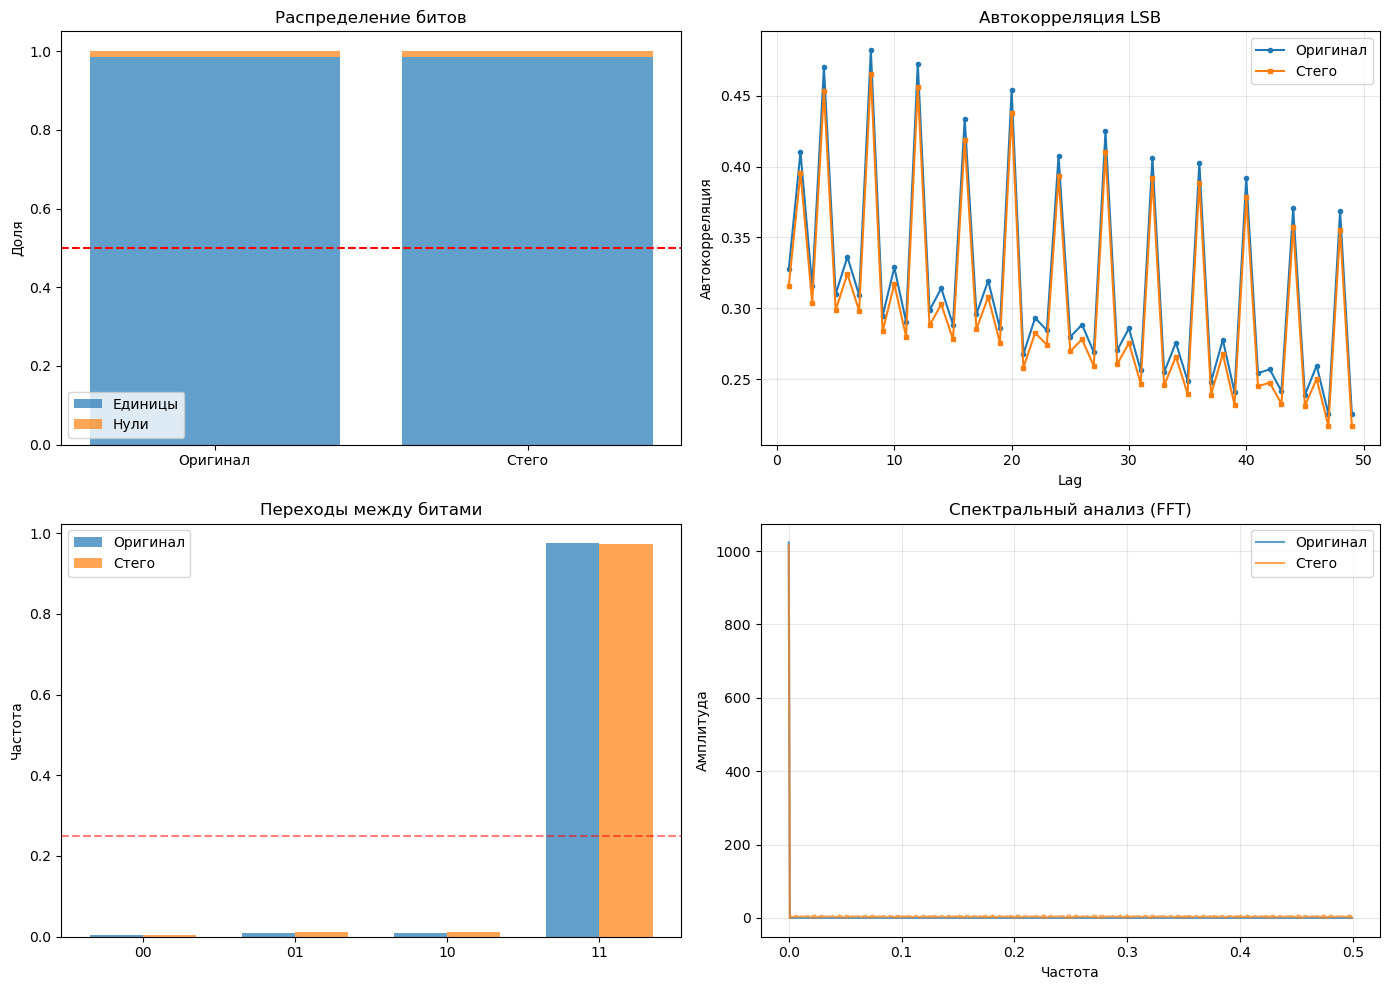


✓ Графики сохранены в 'nist_stego_analysis.png'

ДЕТАЛЬНЫЙ АНАЛИЗ СТЕГОКОНТЕЙНЕРА

NIST Statistical Tests (assess) для: Стегоконтейнер (детально)
Длина последовательности: 100000 бит

Запуск assess с параметрами:
  Длина: 100000 бит
  Файл: test_data_stego.txt
  Команда: /home/riku/Documents/crypto/Indiv/NIST-Statistical-Test-Suite-master/sts/assess 100000

STDOUT от assess:
           G E N E R A T O R    S E L E C T I O N 
           ______________________________________

    [0] Input File                 [1] Linear Congruential
    [2] Quadratic Congruential I   [3] Quadratic Congruential II
    [4] Cubic Congruential         [5] XOR
    [6] Modular Exponentiation     [7] Blum-Blum-Shub
    [8] Micali-Schnorr             [9] G Using SHA-1

   Enter Choice: 

		User Prescribed Input File: 
                S T A T I S T I C A L   T E S T S
                _________________________________

    [01] Frequency                       [02] Block Frequency
    [03] Cumulative Sums       

{}

In [9]:
nist_assess_path = '/home/riku/Documents/crypto/Indiv/NIST-Statistical-Test-Suite-master/sts/assess'

analyzer = NISTSteganographyAnalysis(None, nist_path=nist_assess_path)

# Пути к изображениям
original_path = pic_path
stego_path = stg_path

# Сравнительный анализ
original_results, stego_results = analyzer.compare_images(original_path, stego_path)

# Дополнительно: анализ только стегоизображения
print("\n" + "="*60)
print("ДЕТАЛЬНЫЙ АНАЛИЗ СТЕГОКОНТЕЙНЕРА")
print("="*60)

stego_lsb = analyzer.extract_lsb_bits(stego_path)
analyzer.run_nist_tests(stego_lsb[:100000], "Стегоконтейнер (детально)")

# 3.1 Другой вариант

In [52]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import subprocess
import os
import tempfile

# Если установлен sp800_22_tests
try:
    from sp800_22_tests import *
    USE_SP800 = True
except ImportError:
    USE_SP800 = False
    print("sp800_22_tests не установлен, будем использовать локальный assess")

class NISTSteganographyAnalysis:
    def __init__(self, image_stego, nist_path='./NIST-Statistical-Test-Suite-master/sts/assess'):
        self.image_stego = image_stego
        self.nist_path = nist_path
        self.use_assess = os.path.exists(nist_path)
        
        if self.use_assess:
            print(f"✓ Найден NIST assess: {nist_path}")
        else:
            print(f"⚠ NIST assess не найден: {nist_path}")
            print(f"  Будут использованы только базовые тесты")
    
    def extract_lsb_bits(self, image_path):
        """Извлекает последовательность LSB из изображения"""
        img = Image.open(image_path)
        img_array = np.array(img)
        flat_array = img_array.flatten()
        lsb_sequence = [pixel & 1 for pixel in flat_array]
        return lsb_sequence
    
    def run_nist_assess(self, bit_sequence, test_name="Unknown", num_streams=100):
        """
        Запускает оригинальный NIST assess на последовательности битов
        
        Args:
            bit_sequence: последовательность битов
            test_name: название теста
            num_streams: количество независимых потоков (рекомендуется 100-1000)
        """
        if not self.use_assess:
            print("⚠ assess не найден, используем базовые тесты")
            return self._basic_statistical_tests(bit_sequence)
        
        # Вычисляем длину одного потока
        total_bits = len(bit_sequence)
        stream_length = total_bits // num_streams
        
        # NIST рекомендует минимум 100 бит на поток, лучше 1000+
        if stream_length < 100:
            print(f"⚠ Предупреждение: длина потока {stream_length} < 100 бит")
            # Корректируем количество потоков
            num_streams = total_bits // 1000
            if num_streams < 1:
                num_streams = 1
            stream_length = total_bits // num_streams
            print(f"  Автокоррекция: {num_streams} потоков по {stream_length} бит")
        
        print(f"\n{'='*60}")
        print(f"NIST Statistical Tests (assess) для: {test_name}")
        print(f"Общая длина: {total_bits} бит")
        print(f"Количество потоков: {num_streams}")
        print(f"Длина одного потока: {stream_length} бит")
        print(f"{'='*60}\n")
        
        # Получаем директорию где лежит assess
        assess_dir = os.path.dirname(os.path.abspath(self.nist_path))
        
        # Создаем файл с битами (относительный путь от assess_dir)
        data_filename = 'test_data_stego.txt'
        data_file = os.path.join(assess_dir, data_filename)
        
        with open(data_file, 'w') as f:
            # assess ожидает биты в текстовом формате ASCII (0 и 1)
            # Записываем только нужное количество бит
            total_to_write = num_streams * stream_length
            f.write(''.join(map(str, bit_sequence[:total_to_write])))
        
        try:
            # Интерактивный диалог с assess:
            # 1. Enter Choice (Generator): 0 - Input File
            # 2. User Prescribed Input File: имя_файла
            # 3. Enter Choice (Apply all tests): 1 - YES
            # 4. Select Test (Parameter Adjustments): 0 - continue
            # 5. How many bitstreams?: 1
            # 6. Select input mode: 0 - ASCII
            
            assess_input = f"""0
{data_filename}
1
0
{num_streams}
0
"""
            
            print(f"Запуск assess с параметрами:")
            print(f"  Длина потока: {stream_length} бит")
            print(f"  Количество потоков: {num_streams}")
            print(f"  Файл: {data_filename}")
            print(f"  Команда: {self.nist_path} {stream_length}")
            print()
            
            result = subprocess.run(
                [self.nist_path, str(stream_length)],
                input=assess_input,
                text=True,
                capture_output=True,
                cwd=assess_dir,
                timeout=180
            )
            
            print("="*60)
            print("STDOUT от assess:")
            print("="*60)
            print(result.stdout)
            
            if result.stderr:
                print("\n" + "="*60)
                print("STDERR от assess:")
                print("="*60)
                print(result.stderr)
            
            if result.returncode != 0:
                print(f"\n⚠ assess завершился с кодом {result.returncode}")
            
            # Парсим результаты из файлов
            results = self._parse_assess_results(assess_dir)
            
            return results
            
        except subprocess.TimeoutExpired:
            print("⚠ Timeout при выполнении assess (>180 сек)")
            return {}
        except Exception as e:
            print(f"⚠ Ошибка при запуске assess: {e}")
            import traceback
            traceback.print_exc()
            return {}
        finally:
            # Удаляем временный файл
            if os.path.exists(data_file):
                try:
                    os.remove(data_file)
                    print(f"\n✓ Временный файл удален: {data_filename}")
                except Exception as e:
                    print(f"\n⚠ Не удалось удалить {data_filename}: {e}")
    
    def _parse_assess_results(self, assess_dir):
        """
        Парсит результаты из папки с выходными файлами assess
        """
        results = {}
        
        # assess создает файл finalAnalysisReport.txt в директории experiments
        report_file = os.path.join(assess_dir, 'experiments', 'AlgorithmTesting', 'finalAnalysisReport.txt')
        
        # Альтернативные пути
        alt_paths = [
            os.path.join(assess_dir, 'finalAnalysisReport.txt'),
            os.path.join(assess_dir, 'experiments', 'finalAnalysisReport.txt'),
        ]
        
        # Ищем файл
        found_file = None
        if os.path.exists(report_file):
            found_file = report_file
        else:
            for alt_path in alt_paths:
                if os.path.exists(alt_path):
                    found_file = alt_path
                    break
        
        if not found_file:
            print(f"⚠ Файл отчета не найден.")
            print(f"  Искали в: {report_file}")
            print(f"  Содержимое {assess_dir}:")
            try:
                for root, dirs, files in os.walk(assess_dir):
                    level = root.replace(assess_dir, '').count(os.sep)
                    indent = ' ' * 2 * level
                    print(f'{indent}{os.path.basename(root)}/')
                    subindent = ' ' * 2 * (level + 1)
                    for file in files:
                        if 'report' in file.lower() or 'result' in file.lower():
                            print(f'{subindent}{file} <---')
                        else:
                            print(f'{subindent}{file}')
            except Exception as e:
                print(f"  Ошибка при чтении директории: {e}")
            return results
        
        try:
            with open(found_file, 'r') as f:
                content = f.read()
                
            print("\n" + "="*60)
            print(f"РЕЗУЛЬТАТЫ ИЗ {os.path.basename(found_file)}:")
            print("="*60)
            print(content)
            
            # Парсинг результатов
            # Формат: p-value PASS/FAIL TestName
            lines = content.split('\n')
            for line in lines:
                line = line.strip()
                if not line or line.startswith('-') or line.startswith('='):
                    continue
                    
                # Ищем строки с PASS/FAIL
                if 'PASS' in line or 'FAIL' in line:
                    parts = line.split()
                    if len(parts) >= 2:
                        try:
                            # Первое число - это p-value
                            p_value = None
                            for part in parts:
                                try:
                                    p_value = float(part)
                                    break
                                except ValueError:
                                    continue
                            
                            if p_value is not None:
                                status = 'PASS' in line
                                # Название теста - все что после p-value и PASS/FAIL
                                test_name = line.split('PASS' if status else 'FAIL')[-1].strip()
                                if not test_name:
                                    # Пробуем найти название в начале
                                    for i, part in enumerate(parts):
                                        if part == 'PASS' or part == 'FAIL':
                                            test_name = ' '.join(parts[i+1:]) if i+1 < len(parts) else ' '.join(parts[:i])
                                            break
                                
                                if test_name:
                                    results[test_name] = {
                                        'p_value': p_value,
                                        'passed': status
                                    }
                                    status_str = "✓ PASS" if status else "✗ FAIL"
                                    print(f"{test_name:40} p-value: {p_value:.6f}  {status_str}")
                        except (ValueError, IndexError) as e:
                            continue
            
        except Exception as e:
            print(f"⚠ Ошибка при парсинге результатов: {e}")
            import traceback
            traceback.print_exc()
        
        return results
    
    def run_nist_tests(self, bit_sequence, test_name="Unknown"):
        """
        Запускает набор NIST тестов на последовательности битов.
        Использует assess если доступен, иначе sp800_22_tests или базовые тесты.
        """
        # Приоритет: assess > sp800_22_tests > базовые тесты
        if self.use_assess:
            return self.run_nist_assess(bit_sequence, test_name)
        
        # Преобразуем в строку (некоторые библиотеки требуют строку)
        bit_string = ''.join(map(str, bit_sequence))
        n = len(bit_sequence)
        
        print(f"\n{'='*60}")
        print(f"NIST Statistical Tests для: {test_name}")
        print(f"Длина последовательности: {n} бит")
        print(f"{'='*60}\n")
        
        results = {}
        
        if USE_SP800:
            # Запускаем основные тесты
            tests = [
                ("Frequency (Monobit)", monobit_test),
                ("Block Frequency", block_frequency_test),
                ("Runs", runs_test),
                ("Longest Run of Ones", longest_runs_test),
                ("Binary Matrix Rank", binary_matrix_rank_test),
                ("Spectral (FFT)", spectral_test),
                ("Non-Overlapping Template", non_overlapping_template_matching_test),
                ("Overlapping Template", overlapping_template_matching_test),
                ("Universal Statistical", maurers_universal_test),
                ("Linear Complexity", linear_complexity_test),
                ("Serial", serial_test),
                ("Approximate Entropy", approximate_entropy_test),
                ("Cumulative Sums", cumulative_sums_test),
            ]
            
            for test_name_str, test_func in tests:
                try:
                    # Разные тесты возвращают разные форматы
                    result = test_func(bit_string)
                    
                    # Обработка результата
                    if isinstance(result, tuple):
                        p_value = result[0] if len(result) > 0 else None
                    else:
                        p_value = result
                    
                    # Критерий: p-value >= 0.01 означает прохождение теста
                    passed = p_value >= 0.01 if p_value is not None else False
                    status = "✓ PASS" if passed else "✗ FAIL"
                    
                    results[test_name_str] = {
                        'p_value': p_value,
                        'passed': passed
                    }
                    
                    print(f"{test_name_str:40} p-value: {p_value:.6f if p_value else 'N/A':>10}  {status}")
                    
                except Exception as e:
                    print(f"{test_name_str:40} ERROR: {str(e)}")
                    results[test_name_str] = {'error': str(e)}
        else:
            print("⚠ Библиотека sp800_22_tests не установлена")
            print("Установите: pip install sp800-22-tests")
            # Запускаем базовые тесты вручную
            results = self._basic_statistical_tests(bit_sequence)
        
        return results
    
    def _basic_statistical_tests(self, bit_sequence):
        """Базовые статистические тесты без NIST библиотеки"""
        n = len(bit_sequence)
        results = {}
        
        # 1. Frequency Test (Monobit)
        ones = sum(bit_sequence)
        zeros = n - ones
        expected = n / 2
        chi_square = (ones - expected)**2 / expected + (zeros - expected)**2 / expected
        
        print(f"{'Frequency Test (Manual)':40}")
        print(f"  Ones: {ones}, Zeros: {zeros}")
        print(f"  Chi-square: {chi_square:.4f}")
        print(f"  Expected < 3.841 for α=0.05: {chi_square < 3.841}")
        
        results['frequency'] = {
            'ones': ones,
            'zeros': zeros,
            'chi_square': chi_square,
            'passed': chi_square < 3.841
        }
        
        # 2. Runs Test
        runs = 1
        for i in range(1, n):
            if bit_sequence[i] != bit_sequence[i-1]:
                runs += 1
        
        pi = ones / n
        expected_runs = 2 * n * pi * (1 - pi) + 1
        
        print(f"\n{'Runs Test (Manual)':40}")
        print(f"  Observed runs: {runs}")
        print(f"  Expected runs: {expected_runs:.2f}")
        print(f"  Ratio: {runs/expected_runs:.4f} (должно быть близко к 1)")
        
        results['runs'] = {
            'observed': runs,
            'expected': expected_runs,
            'ratio': runs/expected_runs
        }
        
        # 3. Longest Run Test
        max_run = 0
        current_run = 0
        for bit in bit_sequence:
            if bit == 1:
                current_run += 1
                max_run = max(max_run, current_run)
            else:
                current_run = 0
        
        # Для случайной последовательности ожидаемая самая длинная серия ≈ log2(n)
        expected_max = np.log2(n)
        
        print(f"\n{'Longest Run Test (Manual)':40}")
        print(f"  Longest run of ones: {max_run}")
        print(f"  Expected (≈log2(n)): {expected_max:.2f}")
        
        results['longest_run'] = {
            'max_run': max_run,
            'expected': expected_max
        }
        
        return results
    
    def compare_images(self, original_path, stego_path):
        """
        Сравнивает статистику LSB оригинального и стего изображений
        """
        print("\n" + "="*60)
        print("СРАВНИТЕЛЬНЫЙ АНАЛИЗ")
        print("="*60)
        
        # Извлекаем LSB
        original_lsb = self.extract_lsb_bits(original_path)
        stego_lsb = self.extract_lsb_bits(stego_path)
        
        # Ограничиваем длину для тестов (NIST рекомендует минимум 100 бит, лучше 1000+)
        test_length = min(100000, len(original_lsb), len(stego_lsb))
        
        print(f"\nИспользуем первые {test_length} бит для анализа\n")
        
        # Тестируем оригинал
        print("\n### ОРИГИНАЛЬНОЕ ИЗОБРАЖЕНИЕ ###")
        original_results = self.run_nist_tests(
            original_lsb[:test_length], 
            "Оригинал"
        )
        
        # Тестируем стего
        print("\n### СТЕГОИЗОБРАЖЕНИЕ ###")
        stego_results = self.run_nist_tests(
            stego_lsb[:test_length], 
            "Стегоконтейнер"
        )
        
        # Визуализация
        self.visualize_comparison(original_lsb[:test_length], stego_lsb[:test_length])
        
        return original_results, stego_results
    
    def visualize_comparison(self, original_lsb, stego_lsb):
        """Визуализация распределения битов"""
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # 1. Распределение 0 и 1
        ax = axes[0, 0]
        original_ones = sum(original_lsb) / len(original_lsb)
        stego_ones = sum(stego_lsb) / len(stego_lsb)
        
        x = ['Оригинал', 'Стего']
        y_ones = [original_ones, stego_ones]
        y_zeros = [1 - original_ones, 1 - stego_ones]
        
        ax.bar(x, y_ones, label='Единицы', alpha=0.7)
        ax.bar(x, y_zeros, bottom=y_ones, label='Нули', alpha=0.7)
        ax.set_ylabel('Доля')
        ax.set_title('Распределение битов')
        ax.legend()
        ax.axhline(0.5, color='r', linestyle='--', label='Идеальное (0.5)')
        
        # 2. Автокорреляция
        ax = axes[0, 1]
        max_lag = 50
        original_autocorr = [np.corrcoef(original_lsb[:-i or None], original_lsb[i:])[0, 1] 
                             for i in range(1, max_lag)]
        stego_autocorr = [np.corrcoef(stego_lsb[:-i or None], stego_lsb[i:])[0, 1] 
                          for i in range(1, max_lag)]
        
        ax.plot(range(1, max_lag), original_autocorr, label='Оригинал', marker='o', markersize=3)
        ax.plot(range(1, max_lag), stego_autocorr, label='Стего', marker='s', markersize=3)
        ax.set_xlabel('Lag')
        ax.set_ylabel('Автокорреляция')
        ax.set_title('Автокорреляция LSB')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 3. Гистограмма последовательных пар
        ax = axes[1, 0]
        original_transitions = {'00': 0, '01': 0, '10': 0, '11': 0}
        stego_transitions = {'00': 0, '01': 0, '10': 0, '11': 0}
        
        for i in range(len(original_lsb) - 1):
            key = str(original_lsb[i]) + str(original_lsb[i+1])
            original_transitions[key] += 1
        
        for i in range(len(stego_lsb) - 1):
            key = str(stego_lsb[i]) + str(stego_lsb[i+1])
            stego_transitions[key] += 1
        
        # Нормализация
        total_orig = sum(original_transitions.values())
        total_stego = sum(stego_transitions.values())
        
        original_trans_norm = {k: v/total_orig for k, v in original_transitions.items()}
        stego_trans_norm = {k: v/total_stego for k, v in stego_transitions.items()}
        
        x_pos = np.arange(4)
        width = 0.35
        
        ax.bar(x_pos - width/2, list(original_trans_norm.values()), width, label='Оригинал', alpha=0.7)
        ax.bar(x_pos + width/2, list(stego_trans_norm.values()), width, label='Стего', alpha=0.7)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(list(original_transitions.keys()))
        ax.set_ylabel('Частота')
        ax.set_title('Переходы между битами')
        ax.legend()
        ax.axhline(0.25, color='r', linestyle='--', alpha=0.5, label='Идеальное (0.25)')
        
        # 4. Спектральный анализ (FFT)
        ax = axes[1, 1]
        
        # Преобразуем биты в ±1 для FFT
        original_signal = np.array([2*b - 1 for b in original_lsb[:1024]])
        stego_signal = np.array([2*b - 1 for b in stego_lsb[:1024]])
        
        original_fft = np.abs(np.fft.fft(original_signal))
        stego_fft = np.abs(np.fft.fft(stego_signal))
        
        freqs = np.fft.fftfreq(len(original_signal))
        
        ax.plot(freqs[:len(freqs)//2], original_fft[:len(freqs)//2], label='Оригинал', alpha=0.7)
        ax.plot(freqs[:len(freqs)//2], stego_fft[:len(freqs)//2], label='Стего', alpha=0.7)
        ax.set_xlabel('Частота')
        ax.set_ylabel('Амплитуда')
        ax.set_title('Спектральный анализ (FFT)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('nist_stego_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"\n✓ Графики сохранены в 'nist_stego_analysis.png'")



sp800_22_tests не установлен, будем использовать локальный assess


✓ Найден NIST assess: /home/riku/Documents/crypto/Indiv/NIST-Statistical-Test-Suite-master/sts/assess

СРАВНИТЕЛЬНЫЙ АНАЛИЗ

Используем первые 100000 бит для анализа


### ОРИГИНАЛЬНОЕ ИЗОБРАЖЕНИЕ ###

NIST Statistical Tests (assess) для: Оригинал
Общая длина: 100000 бит
Количество потоков: 100
Длина одного потока: 1000 бит

Запуск assess с параметрами:
  Длина потока: 1000 бит
  Количество потоков: 100
  Файл: test_data_stego.txt
  Команда: /home/riku/Documents/crypto/Indiv/NIST-Statistical-Test-Suite-master/sts/assess 1000

STDOUT от assess:
           G E N E R A T O R    S E L E C T I O N 
           ______________________________________

    [0] Input File                 [1] Linear Congruential
    [2] Quadratic Congruential I   [3] Quadratic Congruential II
    [4] Cubic Congruential         [5] XOR
    [6] Modular Exponentiation     [7] Blum-Blum-Shub
    [8] Micali-Schnorr             [9] G Using SHA-1

   Enter Choice: 

		User Prescribed Input File: 
                S T A T

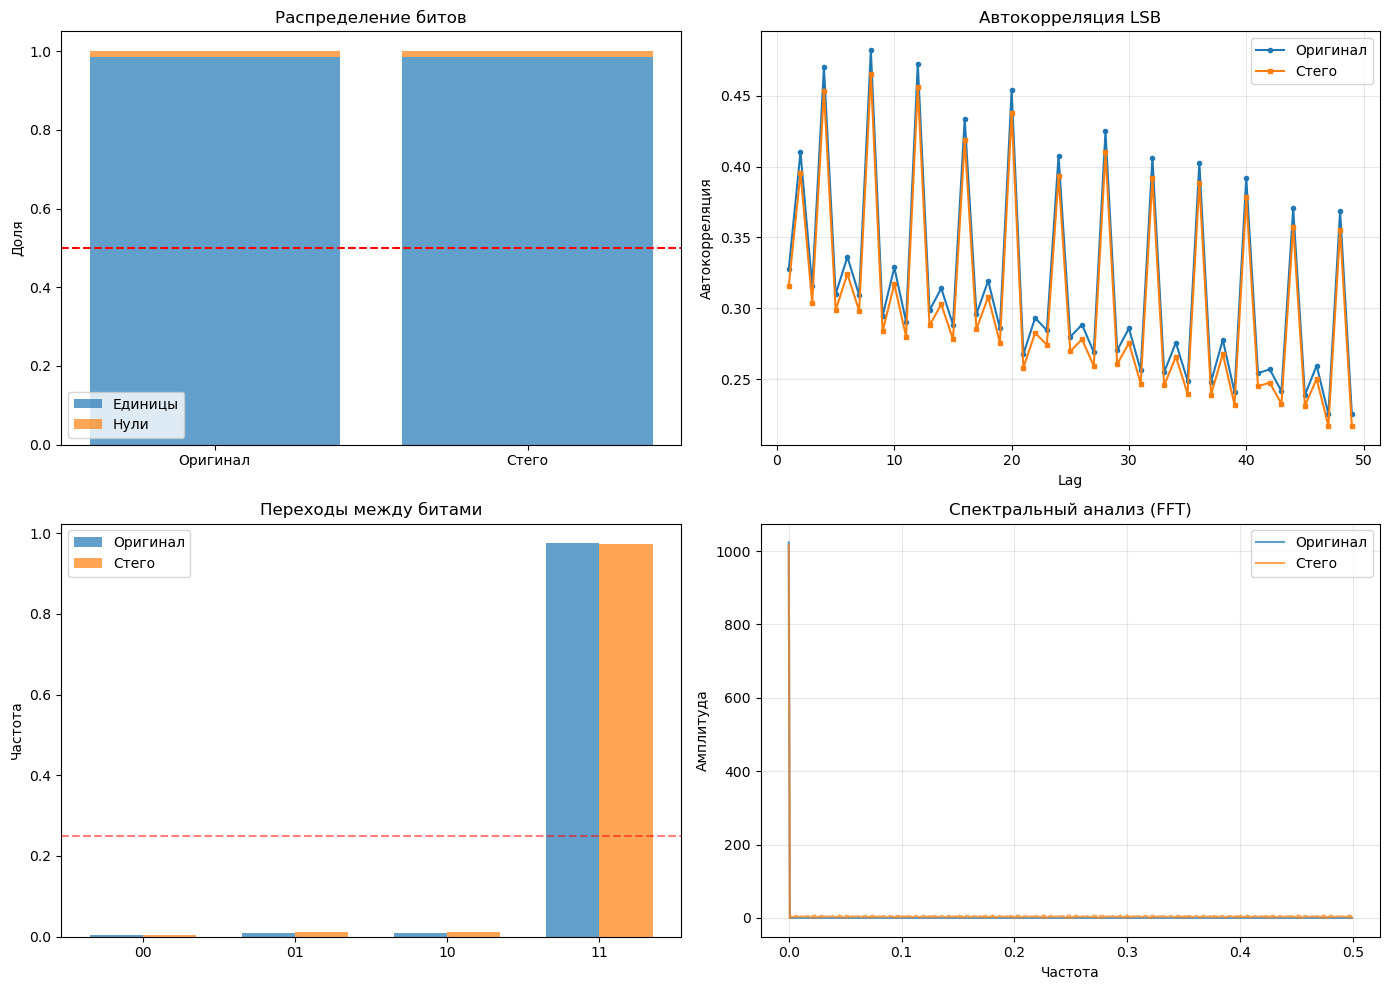


✓ Графики сохранены в 'nist_stego_analysis.png'

ДЕТАЛЬНЫЙ АНАЛИЗ СТЕГОКОНТЕЙНЕРА

NIST Statistical Tests (assess) для: Стегоконтейнер (детально)
Общая длина: 100000 бит
Количество потоков: 100
Длина одного потока: 1000 бит

Запуск assess с параметрами:
  Длина потока: 1000 бит
  Количество потоков: 100
  Файл: test_data_stego.txt
  Команда: /home/riku/Documents/crypto/Indiv/NIST-Statistical-Test-Suite-master/sts/assess 1000

STDOUT от assess:
           G E N E R A T O R    S E L E C T I O N 
           ______________________________________

    [0] Input File                 [1] Linear Congruential
    [2] Quadratic Congruential I   [3] Quadratic Congruential II
    [4] Cubic Congruential         [5] XOR
    [6] Modular Exponentiation     [7] Blum-Blum-Shub
    [8] Micali-Schnorr             [9] G Using SHA-1

   Enter Choice: 

		User Prescribed Input File: 
                S T A T I S T I C A L   T E S T S
                _________________________________

    [01] Frequency     

{}

In [53]:
nist_assess_path = '/home/riku/Documents/crypto/Indiv/NIST-Statistical-Test-Suite-master/sts/assess'

analyzer = NISTSteganographyAnalysis(None, nist_path=nist_assess_path)

# Пути к изображениям
original_path = pic_path
stego_path = stg_path

# Сравнительный анализ
original_results, stego_results = analyzer.compare_images(original_path, stego_path)

# Дополнительно: анализ только стегоизображения
print("\n" + "="*60)
print("ДЕТАЛЬНЫЙ АНАЛИЗ СТЕГОКОНТЕЙНЕРА")
print("="*60)

stego_lsb = analyzer.extract_lsb_bits(stego_path)
analyzer.run_nist_tests(stego_lsb[:100000], "Стегоконтейнер (детально)")

# 4. Модификация с хэшем